In [1]:
import xarray as xr
import yt
import os
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs

ddir = os.path.join(yt.config.ytcfg.get('yt','test_data_dir'), 'sample_nc')
      

# https://ds.iris.edu/files/products/emc/emc-files/GYPSUM_percent.nc : a global model
# https://ds.iris.edu/files/products/emc/emc-files/wUS-SH-2010_percent.nc : a non-global model covering the western US


datasets = {
    "internal_geographic_partial": os.path.join(ddir,'wUS-SH-2010_percent.nc'), 
    "internal_geographic_global": os.path.join(ddir,'GYPSUM_percent.nc'), 
}


In [2]:
def get_widths(x):
    # calculates the cell width from an array of observation points, preserving
    # the min/max of the ranges. 
    extrema = [x.min(), x.max()]
    
    # calculate edges of cells, preserving data min/max.
    edges = (x[1:] +x[0:-1])/2
    edges = np.concatenate([np.array([extrema[0]]), edges, np.array([extrema[1]])])                        
    wids = edges[1:] - edges[0:-1]
    return wids.astype(np.float64), extrema


In [3]:
def _read_data(handle):
    def _reader(grid, field_name, return_dask=False):
        ftype, fname = field_name
        si = grid.get_global_startindex()
        ei = si + grid.ActiveDimensions
        var = getattr(handle, fname)  # variables are top-level attrs of xr datasets        
        data = var[si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]
        if return_dask:            
            return data        
        return data.values

    return _reader

In [71]:
def load_xr_dask_grid(
    xr_handle,    
    length_unit=None,
    n_yt_chunks=1,
    sim_time=0.0,
    mass_unit=None,
    time_unit=None,
    velocity_unit=None,
    magnetic_unit=None,
    periodicity=(True, True, True),    
    unit_system="cgs",
    default_species_fields=None,
    *,    
    parameters=None,
    fields = None
):
  
    from yt.frontends.stream.data_structures import (
        StreamDataset,
        StreamDictFieldHandler,
        StreamHandler,
    )
    from yt.frontends.stream.definitions import (
        assign_particle_data,
        process_data,
        set_particle_types,
    )

    from yt.utilities.decompose import decompose_array, get_psize
    
    # the fields we want to read
    if fields is None:
        fields = list(xr_handle.data_vars)  
    
    # domain setup
    geometry=("internal_geographic", ("depth", "latitude", "longitude"))
    depth_wids, deprng = get_widths(xr_handle.depth.data)
    lon_wids, lonrng = get_widths(xr_handle.longitude.data)
    lat_wids, latrng = get_widths(xr_handle.latitude.data)

    bbox = np.array([
        deprng,   
        latrng,
        lonrng
    ])
    
    domain_left_edge = np.array(bbox[:, 0], "float64")
    domain_right_edge = np.array(bbox[:, 1], "float64")    
    cell_widths = [[depth_wids, lat_wids, lon_wids]]
    dims = ['depth', 'latitude', 'longitude']
    
    domain_dimensions = np.array(xr_handle.data_vars[fields[0]].shape)
                    
                
    # get the reader instance, set our data dictionary
    reader = _read_data(xr_handle)                
    data = {fld: reader for fld in fields}
    
    field_units, data, number_of_particles = process_data(
        data, grid_dims=tuple(domain_dimensions)
    )
    
    
    # setup the grids
    sfh = StreamDictFieldHandler()
       
    grid_levels = np.zeros(n_yt_chunks, dtype="int32").reshape((n_yt_chunks, 1))        
    if n_yt_chunks > 1:  
        
        
        psize = get_psize(np.array(domain_dimensions), n_yt_chunks)
        grid_left_edges, grid_right_edges, grid_shapes, slices = decompose_array(
            domain_dimensions, psize, bbox
        )    
        grid_dimensions = np.array([shape for shape in grid_shapes], dtype="int32")
        
        grid_cell_widths = []        
        for gid in range(n_yt_chunks):
            new_grid = {
                "left_edge": grid_left_edges[gid],
                "right_edge": grid_right_edges[gid],            
                "dimensions": grid_shapes[gid],
                "level": 0,
            }
            
            depth_wids, deprng = get_widths(xr_handle.depth.data)
            lon_wids, lonrng = get_widths(xr_handle.longitude.data)
            lat_wids, latrng = get_widths(xr_handle.latitude.data)
            
            grid_cell_widths.append([[depth_wids, lat_wids, lon_wids]])
            
            new_grid.update(data)  # copy over the reader for all the fields                
            sfh.update({gid: new_grid})
        
    else:        
        sfh.update({0: data})
        grid_left_edges = domain_left_edge
        grid_right_edges = domain_right_edge
        grid_dimensions = domain_dimensions.reshape(n_yt_chunks, 3).astype("int32")
        grid_cell_widths = cell_widths
        
    if length_unit is None:
        length_unit = 1
    if mass_unit is None:
        mass_unit = "code_mass"
    if time_unit is None:
        time_unit = "code_time"
    if velocity_unit is None:
        velocity_unit = "code_velocity"
    if magnetic_unit is None:
        magnetic_unit = "code_magnetic"

    handler = StreamHandler(
        grid_left_edges,
        grid_right_edges,
        grid_dimensions,
        grid_levels,
        -np.ones(n_yt_chunks, dtype="int64"),
        np.zeros(n_yt_chunks, dtype="int64").reshape(n_yt_chunks, 1),  # particle count
        np.zeros(n_yt_chunks).reshape((n_yt_chunks, 1)),
        sfh,
        field_units,
        (length_unit, mass_unit, time_unit, velocity_unit, magnetic_unit),
        particle_types=None,
        periodicity=periodicity,
        cell_widths=grid_cell_widths,
        parameters=parameters,
    )

    handler.name = "UniformGridData"
    handler.domain_left_edge = domain_left_edge
    handler.domain_right_edge = domain_right_edge
    handler.refine_by = 2
    if np.all(domain_dimensions[1:] == 1):
        dimensionality = 1
    elif domain_dimensions[2] == 1:
        dimensionality = 2
    else:
        dimensionality = 3
    handler.dimensionality = dimensionality
    handler.domain_dimensions = domain_dimensions
    handler.simulation_time = sim_time
    handler.cosmology_simulation = 0

    sds = StreamDataset(
        handler,
        geometry=geometry,
        unit_system=unit_system,
        default_species_fields=default_species_fields,
    )

    return sds

In [81]:
# open the handle
xr_chunksize = None
fi = datasets["internal_geographic_global"]
xr_handle = xr.open_dataset(fi, chunks=xr_chunksize)

In [73]:
ds = load_xr_dask_grid(xr_handle, n_yt_chunks=1)

yt : [INFO     ] 2022-09-12 15:54:02,830 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 15:54:02,831 Parameters: domain_dimensions         = [100 181 361]
yt : [INFO     ] 2022-09-12 15:54:02,832 Parameters: domain_left_edge          = [   0.  -90. -180.]
yt : [INFO     ] 2022-09-12 15:54:02,833 Parameters: domain_right_edge         = [2900.   90.  180.]
yt : [INFO     ] 2022-09-12 15:54:02,833 Parameters: cosmological_simulation   = 0


In [78]:
ds.domain_width

unyt_array([2900.,  180.,  360.], 'code_length')

In [74]:
ds.index

yt : [INFO     ] 2022-09-12 15:54:56,213 xlim = -180.000000 180.000000
yt : [INFO     ] 2022-09-12 15:54:56,213 ylim = -90.000000 90.000000
yt : [INFO     ] 2022-09-12 15:54:56,213 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2022-09-12 15:54:56,215 xlim = -180.000000 180.000000
yt : [INFO     ] 2022-09-12 15:54:56,215 ylim = -90.000000 90.000000
yt : [INFO     ] 2022-09-12 15:54:56,217 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



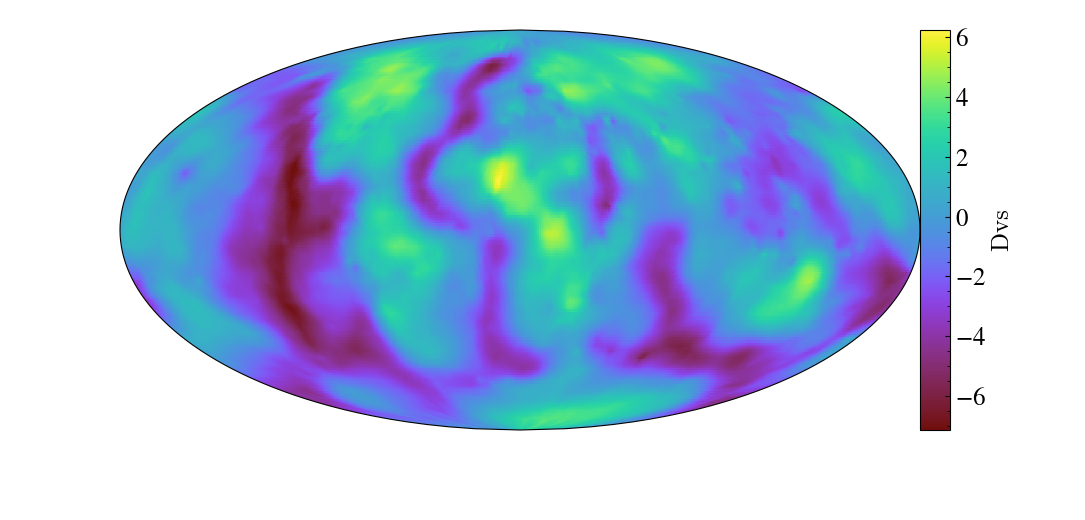

In [80]:
c = ds.domain_center
c[0] = 50
fld = ("stream", "dvs")
slc = yt.SlicePlot(ds, "depth", fld, center = c)
slc.set_log(fld, False)
slc.show()

In [82]:
ds = load_xr_dask_grid(xr_handle, n_yt_chunks=4)

yt : [INFO     ] 2022-09-12 15:55:14,433 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 15:55:14,434 Parameters: domain_dimensions         = [100 181 361]
yt : [INFO     ] 2022-09-12 15:55:14,435 Parameters: domain_left_edge          = [   0.  -90. -180.]
yt : [INFO     ] 2022-09-12 15:55:14,436 Parameters: domain_right_edge         = [2900.   90.  180.]
yt : [INFO     ] 2022-09-12 15:55:14,436 Parameters: cosmological_simulation   = 0


In [83]:
ds.index

IndexError: list index out of range

In [86]:
xr_handle = xr.open_dataset(fi, chunks=10)
xr_handle.dvs

,Array,Chunk
Bytes,24.93 MiB,3.91 kiB
Shape,"(100, 181, 361)","(10, 10, 10)"
Count,7031 Tasks,7030 Chunks
Type,float32,numpy.ndarray


In [88]:
xr_handle.dvs.chunksizes

Frozen({'depth': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10), 'latitude': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1), 'longitude': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1)})